# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
from tensorflow.keras.layers import Dense, LSTM, Bidirectional


# Importing the Dataset



- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




In [2]:

# Define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['Mach Number', 'Altitude', 'Sea-level temperature']
sensor_names = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow"
]

col_names = index_names + setting_names + sensor_names

# Read data
train = pd.read_csv('train_FD003.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD003.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD003.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()


,unit_nr,time_cycles,Mach Number,Altitude,Sea-level temperature,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [3]:
train.shape

(24720, 26)

In [4]:
y_test.shape

(100, 1)

In [5]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [6]:
test.shape

(16596, 26)

In [7]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [8]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [9]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [10]:
train.describe()

,unit_nr,time_cycles,Mach Number,Altitude,Sea-level temperature,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,2.472000e+04,24720.000000,24720.000000,24720.000000,2.472000e+04,...,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,5.186700e+02,642.457858,1588.079175,1404.471212,1.462000e+01,...,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024
std,29.348985,98.846675,0.002194,0.000294,0.0,6.684921e-11,0.523031,6.810418,9.773178,3.602525e-12,...,3.255314,0.158121,16.504118,0.060512,1.750371e-14,1.761459,0.0,0.0,0.248865,0.149234
min,1.000000,1.000000,-0.008600,-0.000600,100.0,5.186700e+02,640.840000,1564.300000,1377.060000,1.462000e+01,...,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.080000,1583.280000,1397.187500,1.462000e+01,...,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,5.186700e+02,642.400000,1587.520000,1402.910000,1.462000e+01,...,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600
75%,74.000000,191.000000,0.001500,0.000300,100.0,5.186700e+02,642.790000,1592.412500,1410.600000,1.462000e+01,...,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300
max,100.000000,525.000000,0.008600,0.000700,100.0,5.186700e+02,645.110000,1615.390000,1441.160000,1.462000e+01,...,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500


In [11]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('Sea-level temperature',axis=1)

In [12]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [13]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),Engine pressure ratio (P50/P2),...,Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [14]:
train.head(5)

,unit_nr,time_cycles,Mach Number,Altitude,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),bypass-duct pressure (psia),...,Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,-0.0005,0.0004,518.67,642.36,1583.23,1396.84,14.62,21.61,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,518.67,642.50,1584.69,1396.89,14.62,21.61,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,518.67,642.18,1582.35,1405.61,14.62,21.61,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,518.67,642.92,1585.61,1392.27,14.62,21.61,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,518.67,641.68,1588.63,1397.65,14.62,21.61,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


## Plotting of RUL

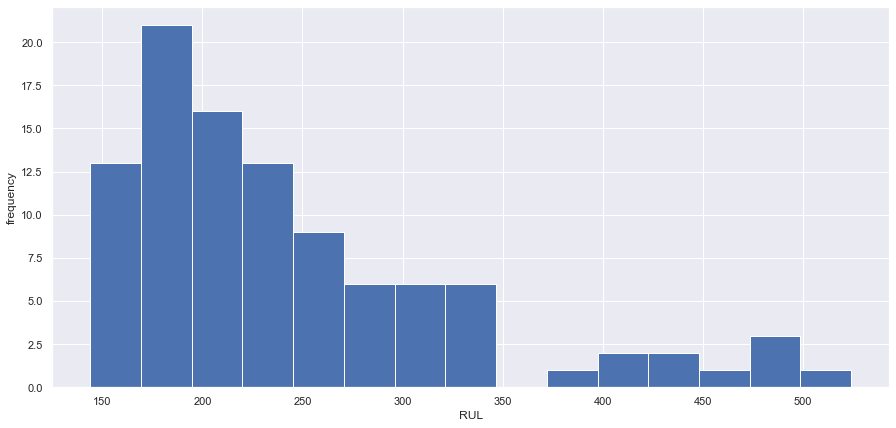

In [15]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [16]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as on 
# now we will keep it as it.


## Plotting of Sensor Values Vs RUL

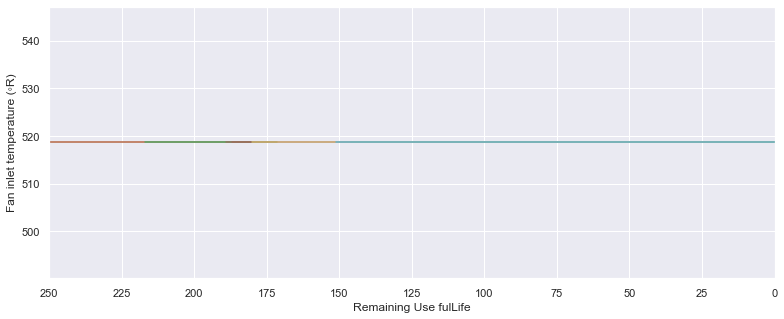

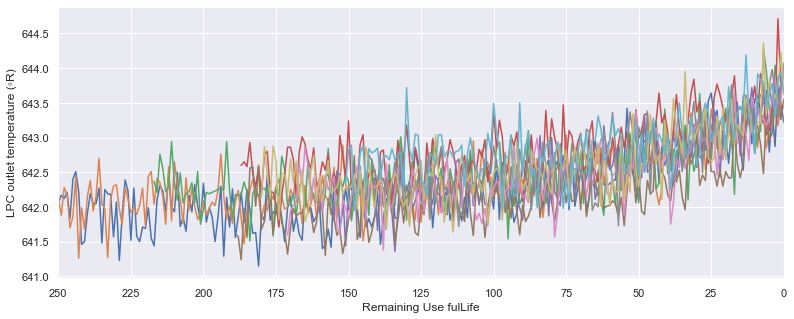

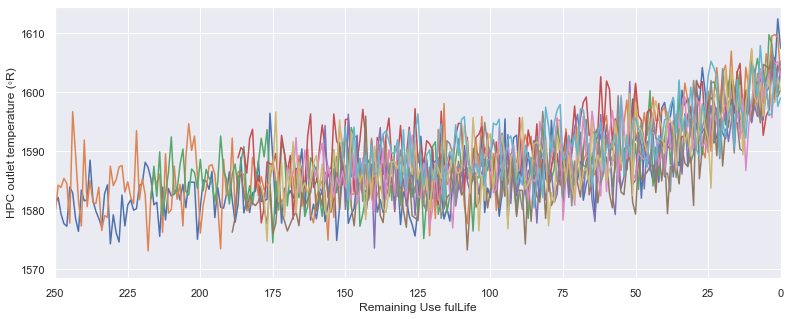

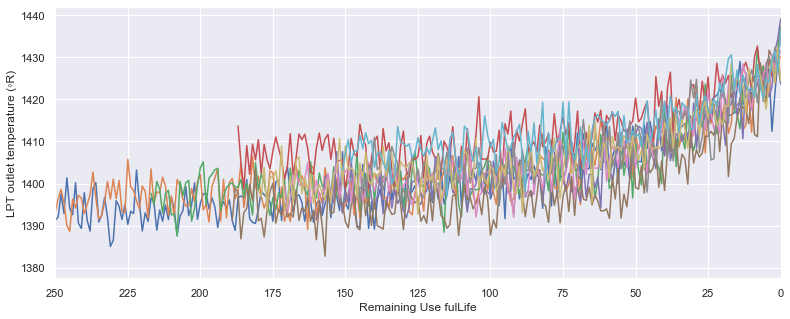

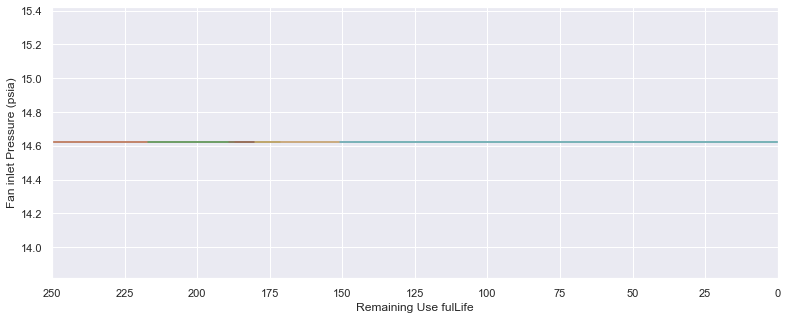

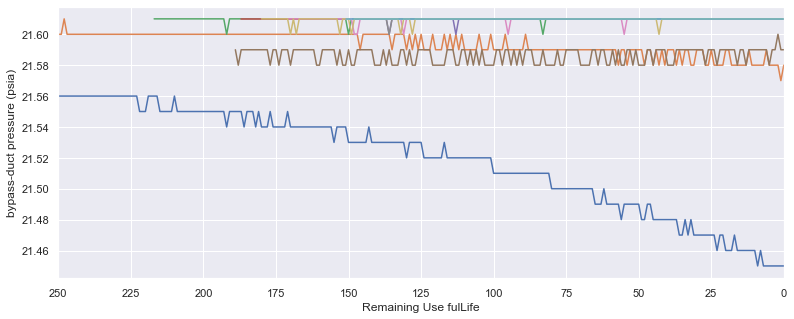

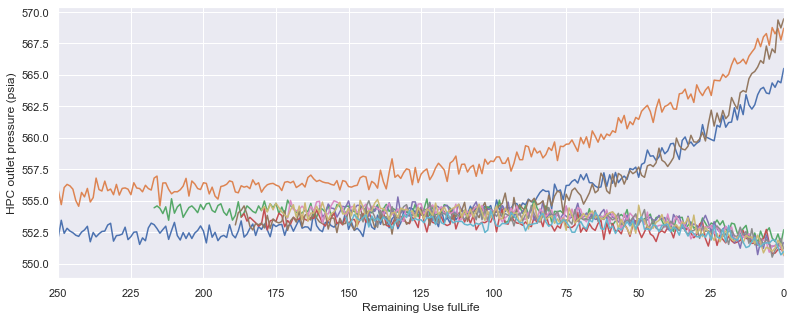

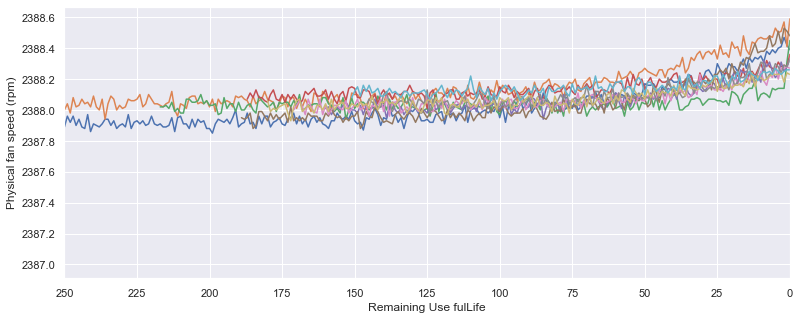

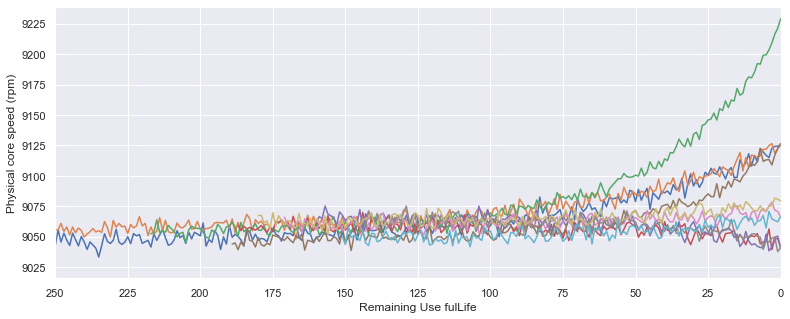

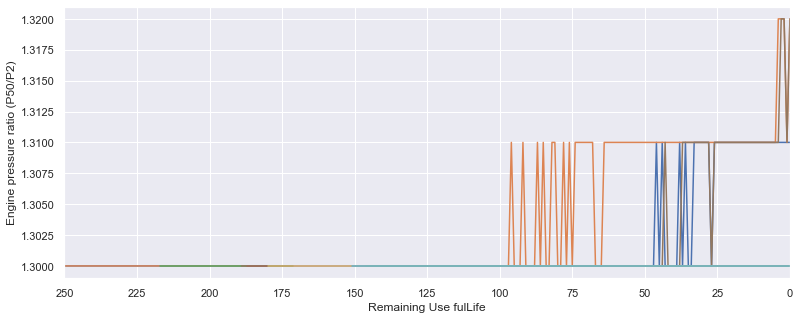

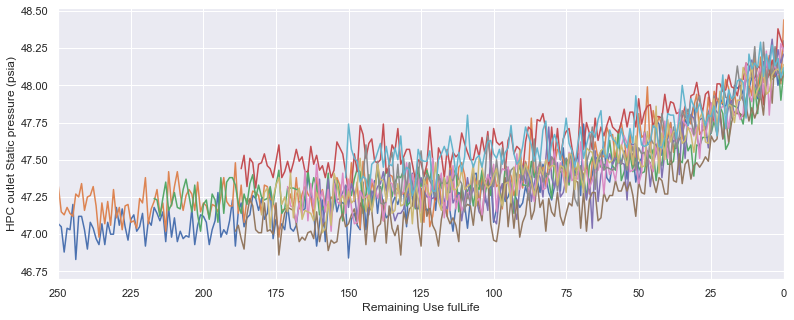

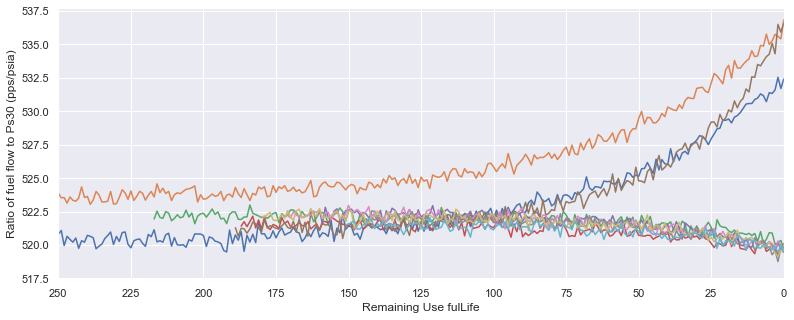

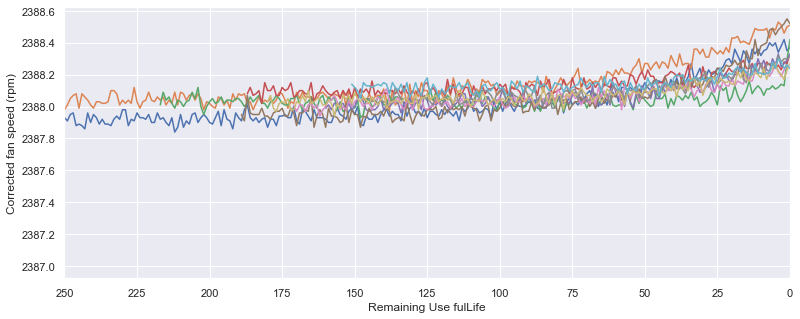

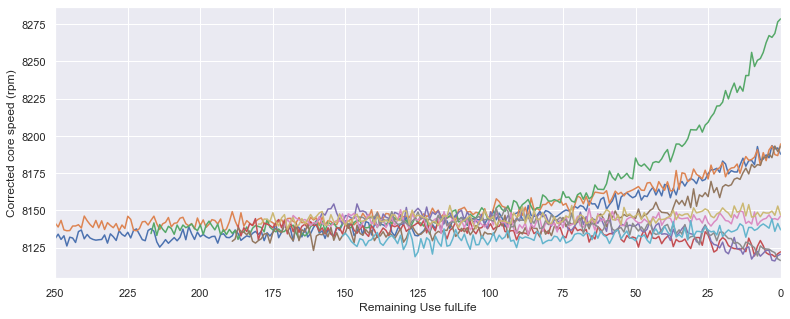

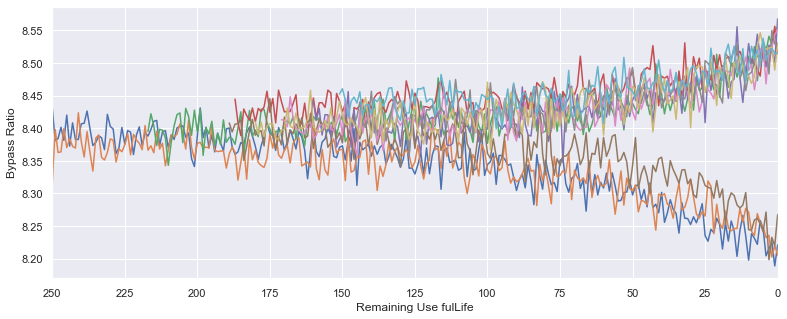

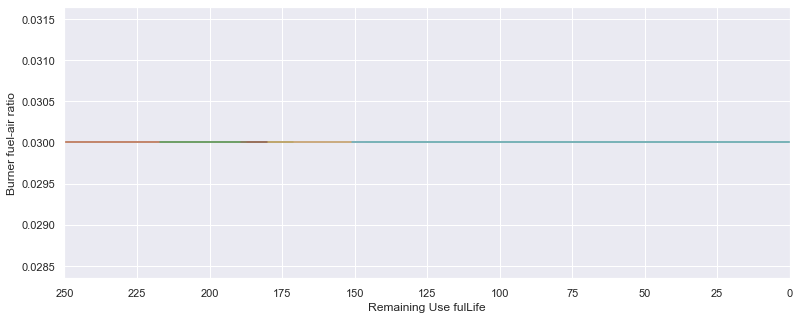

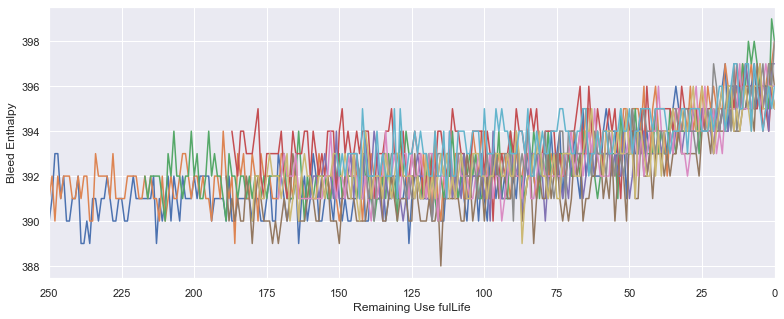

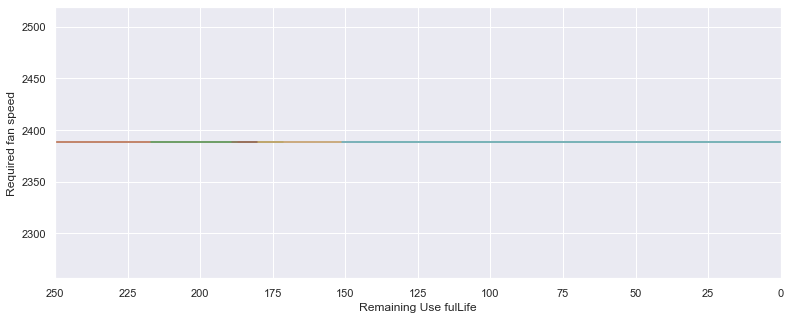

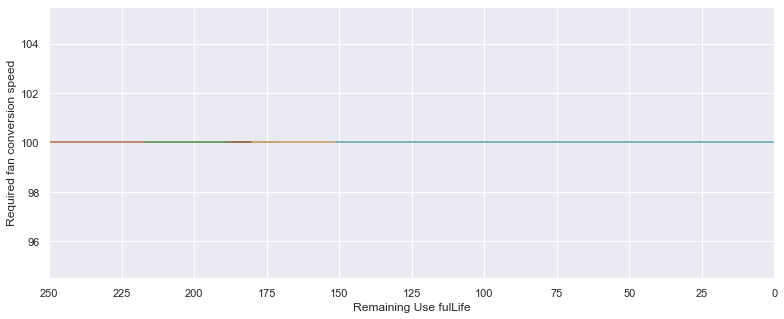

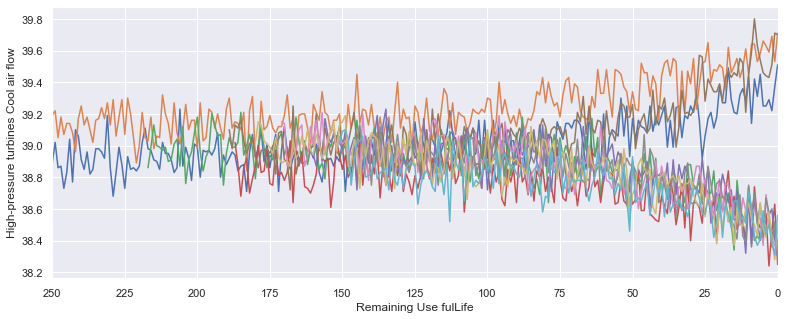

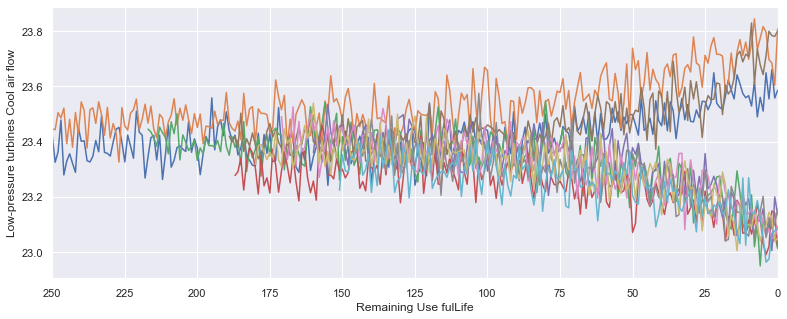

In [17]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

## Boxplots to find outliers

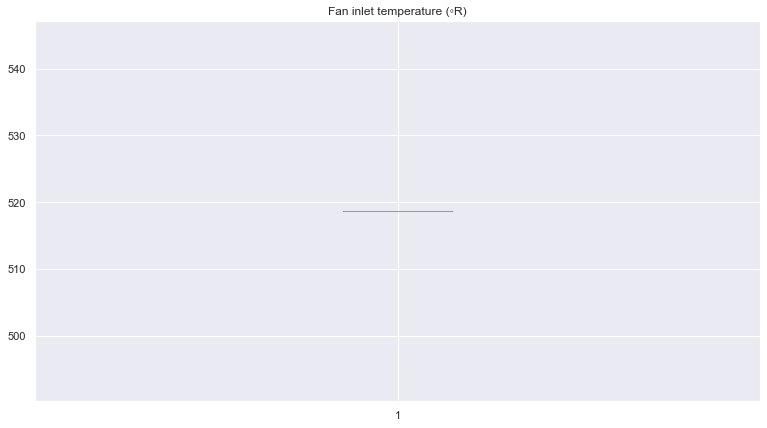

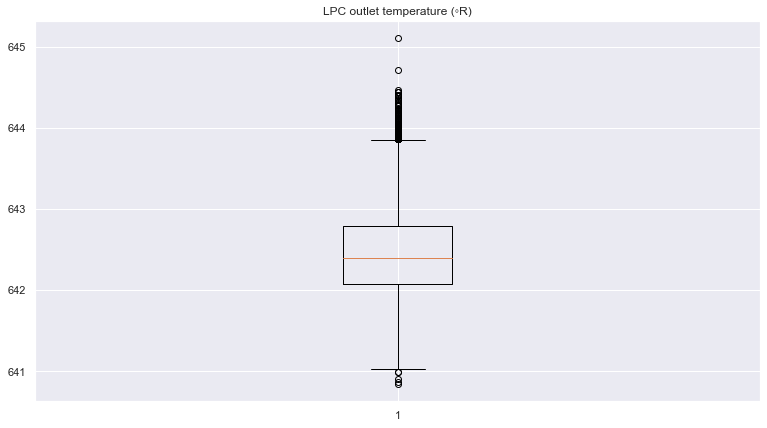

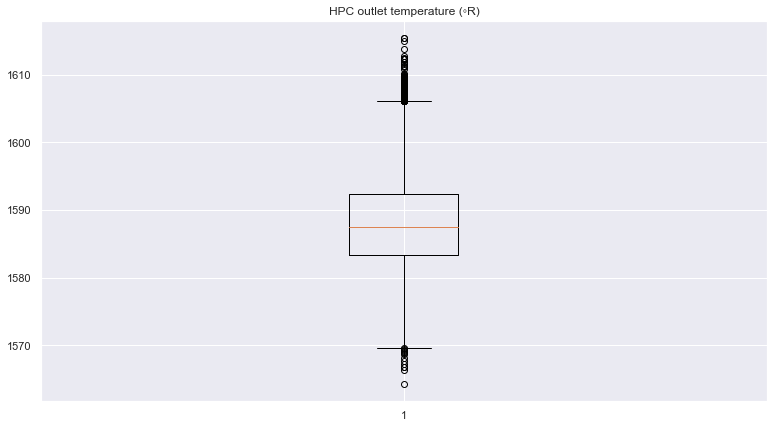

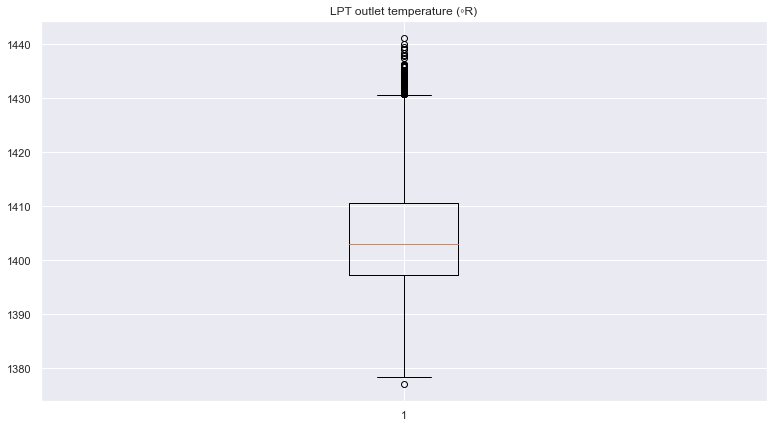

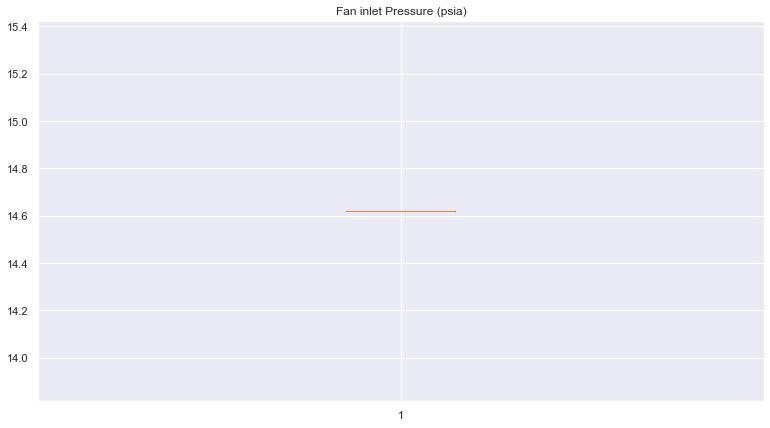

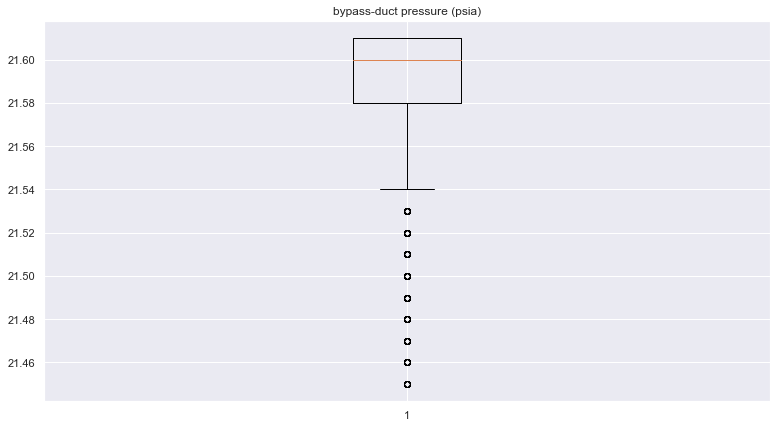

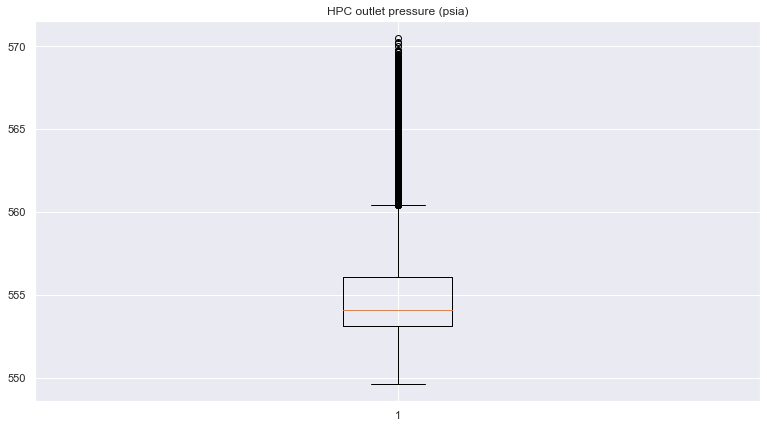

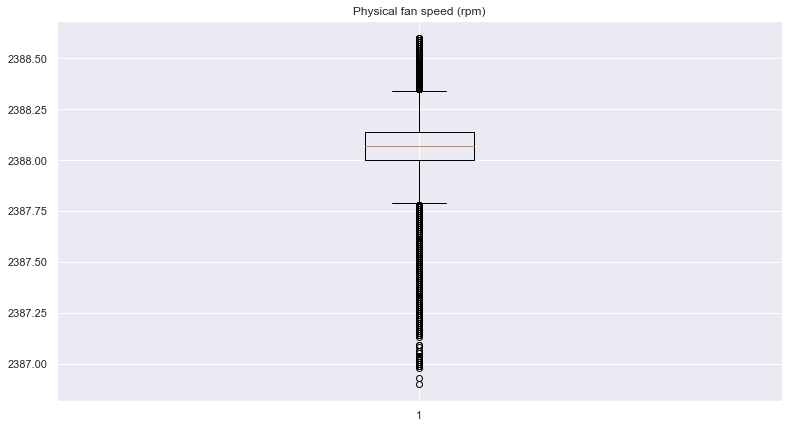

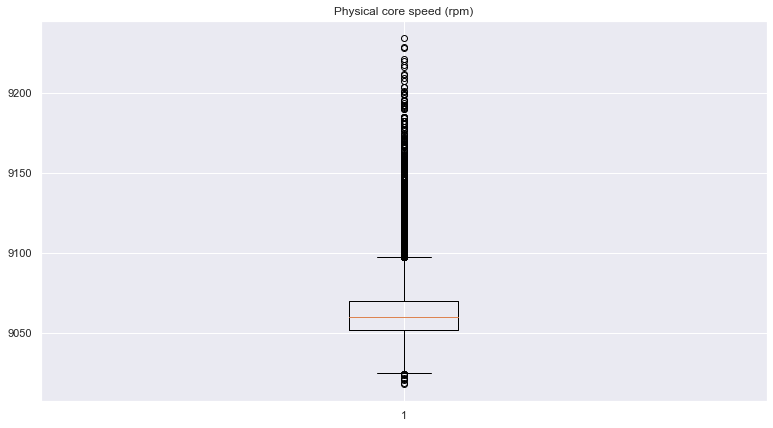

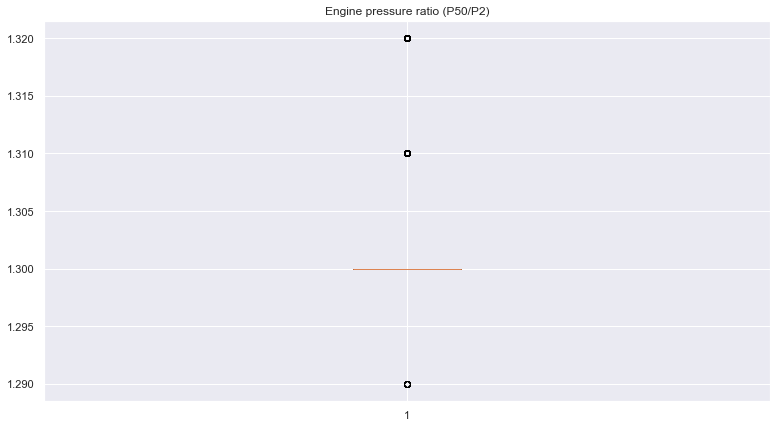

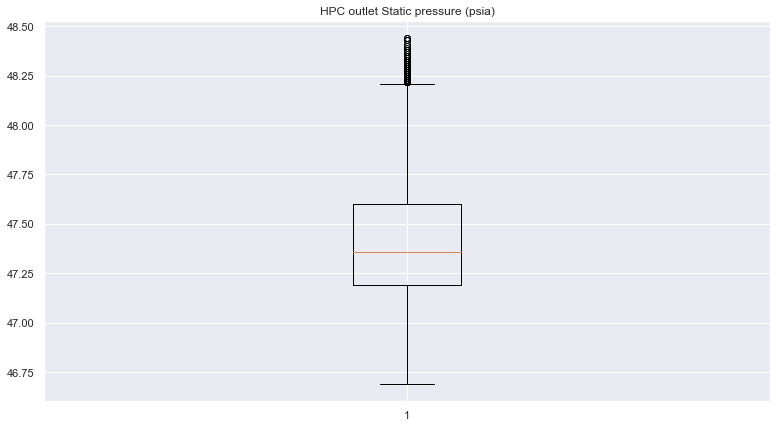

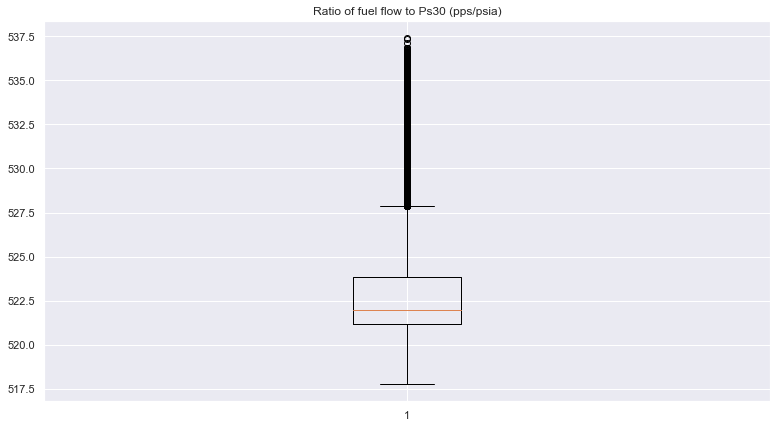

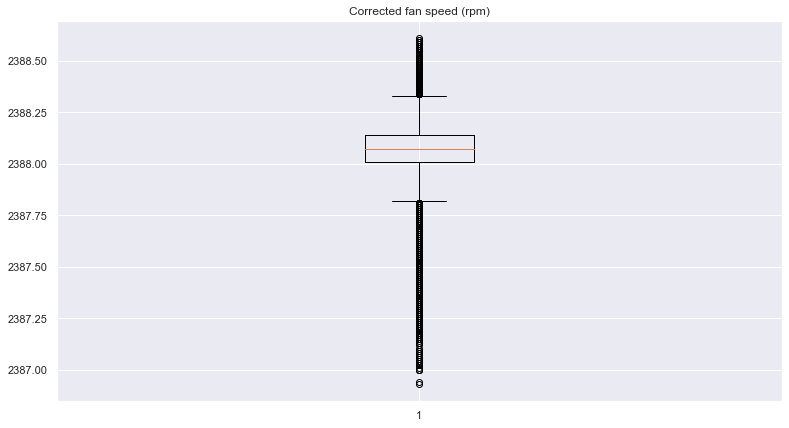

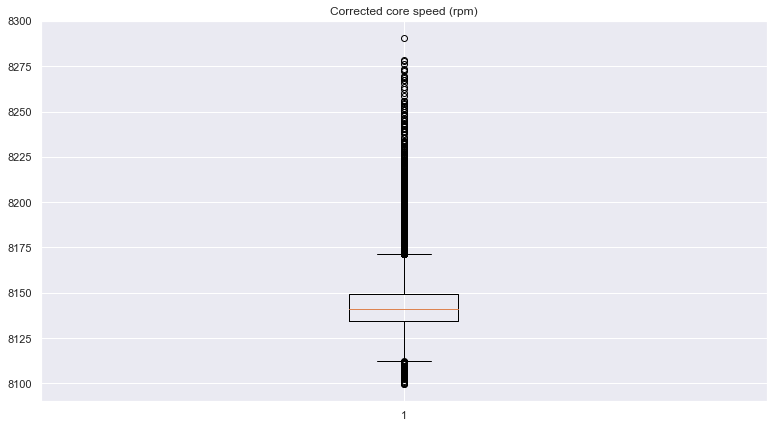

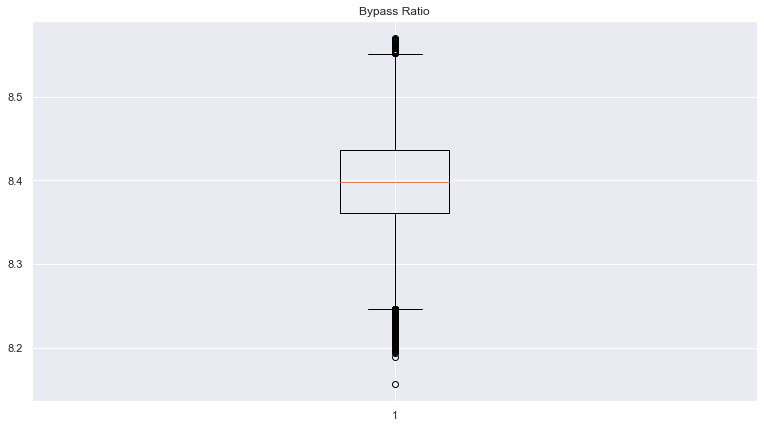

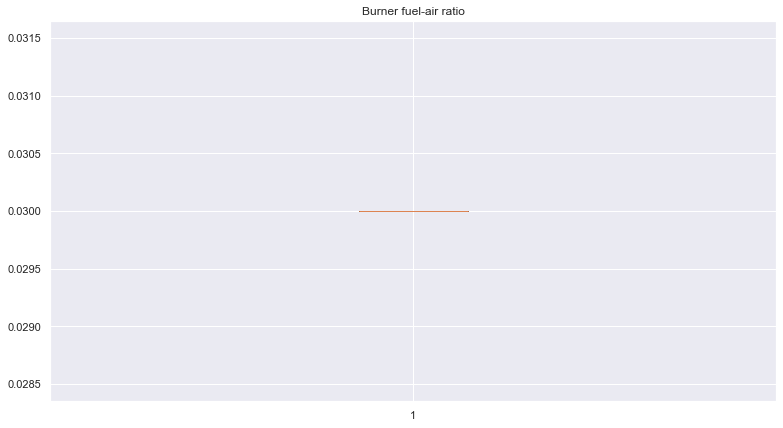

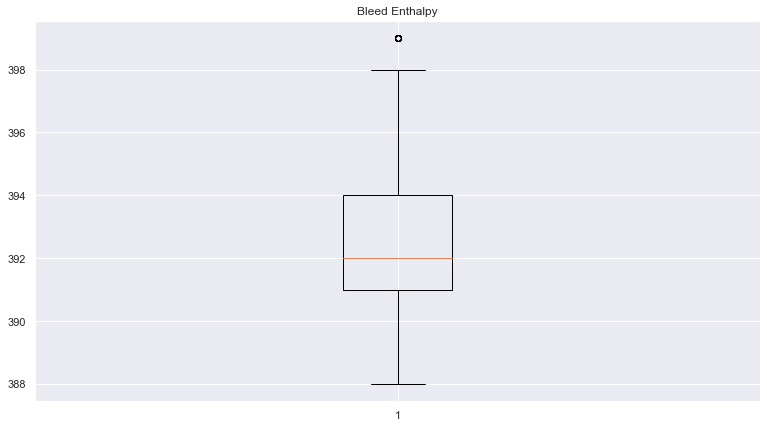

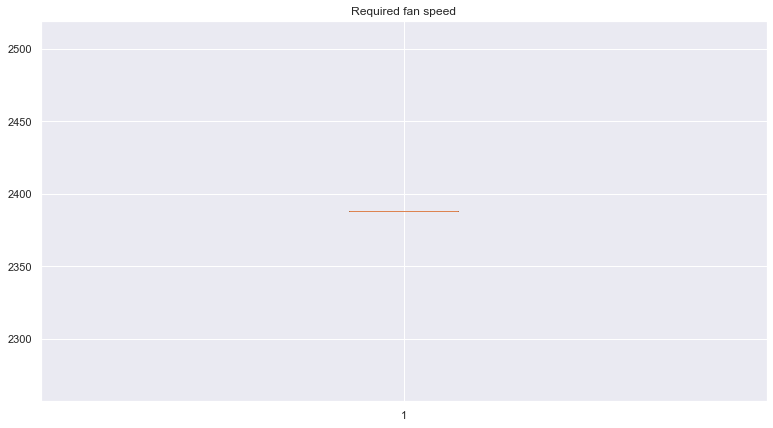

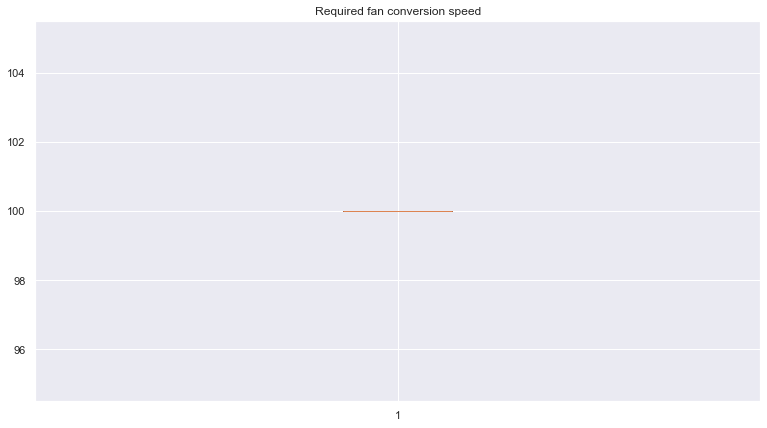

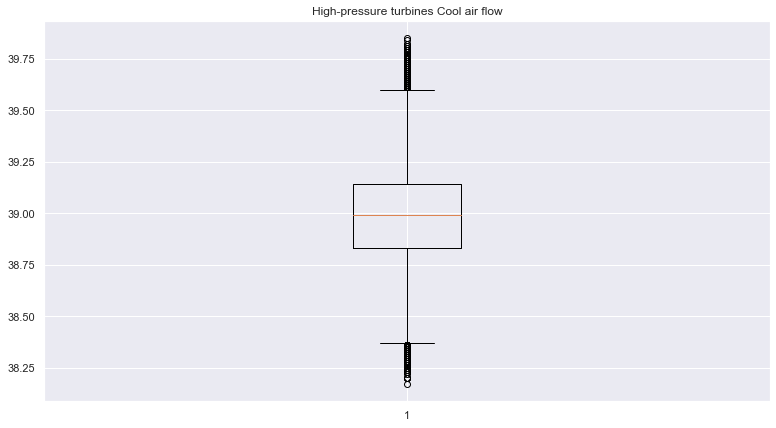

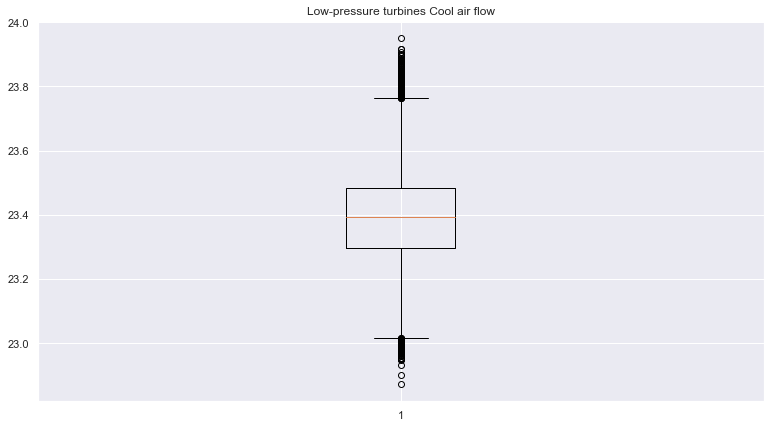

In [18]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

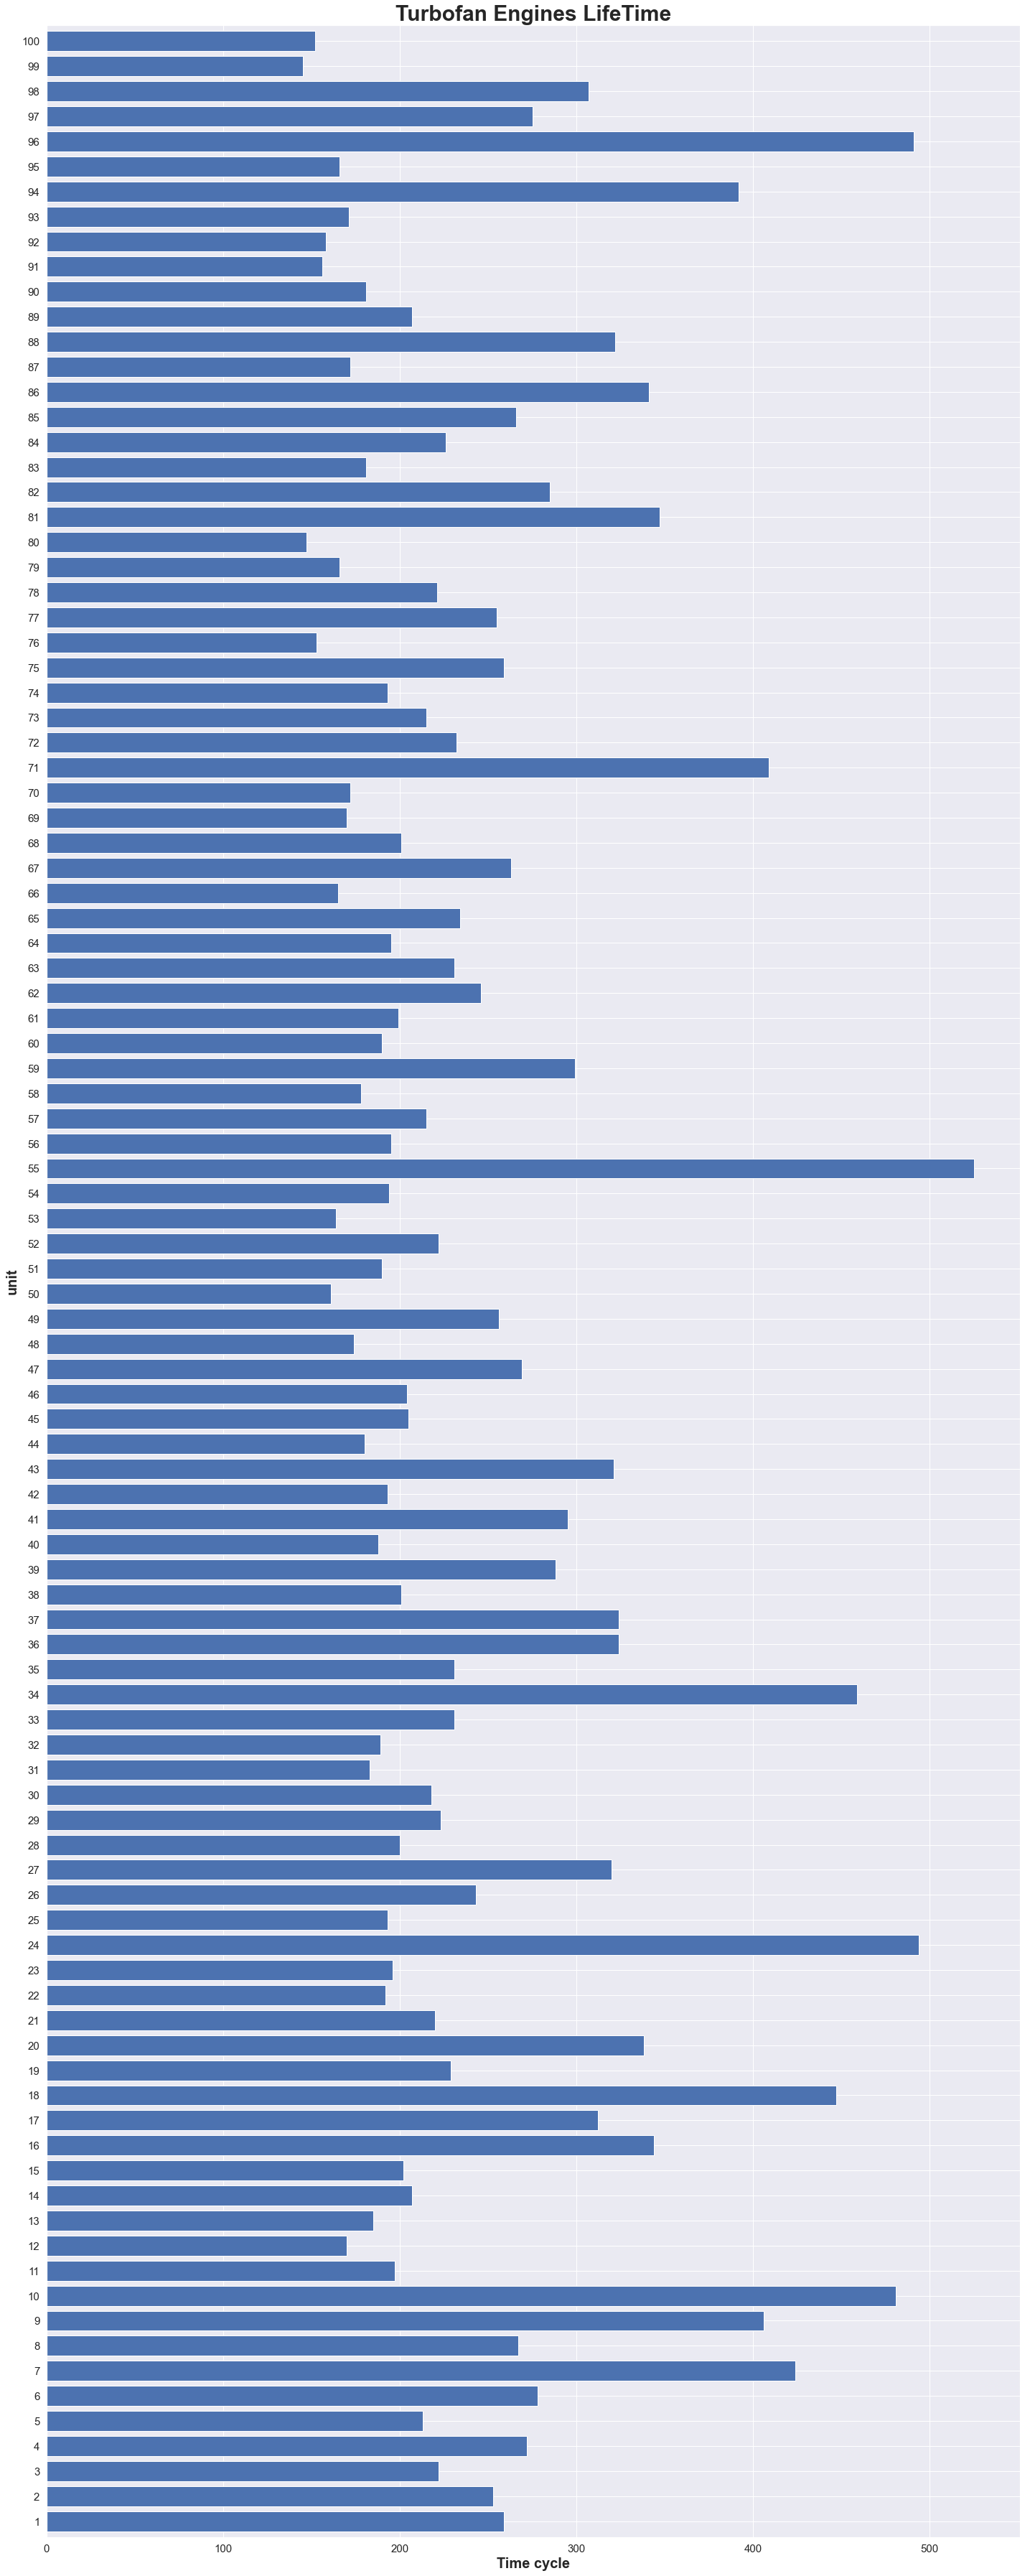

In [19]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

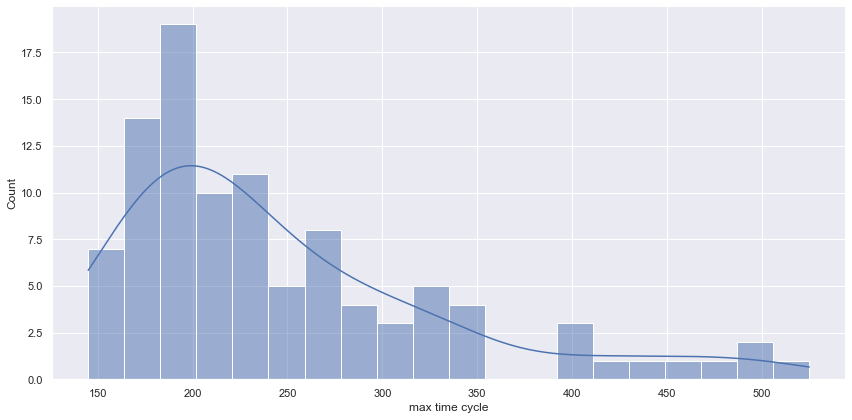

In [20]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [21]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

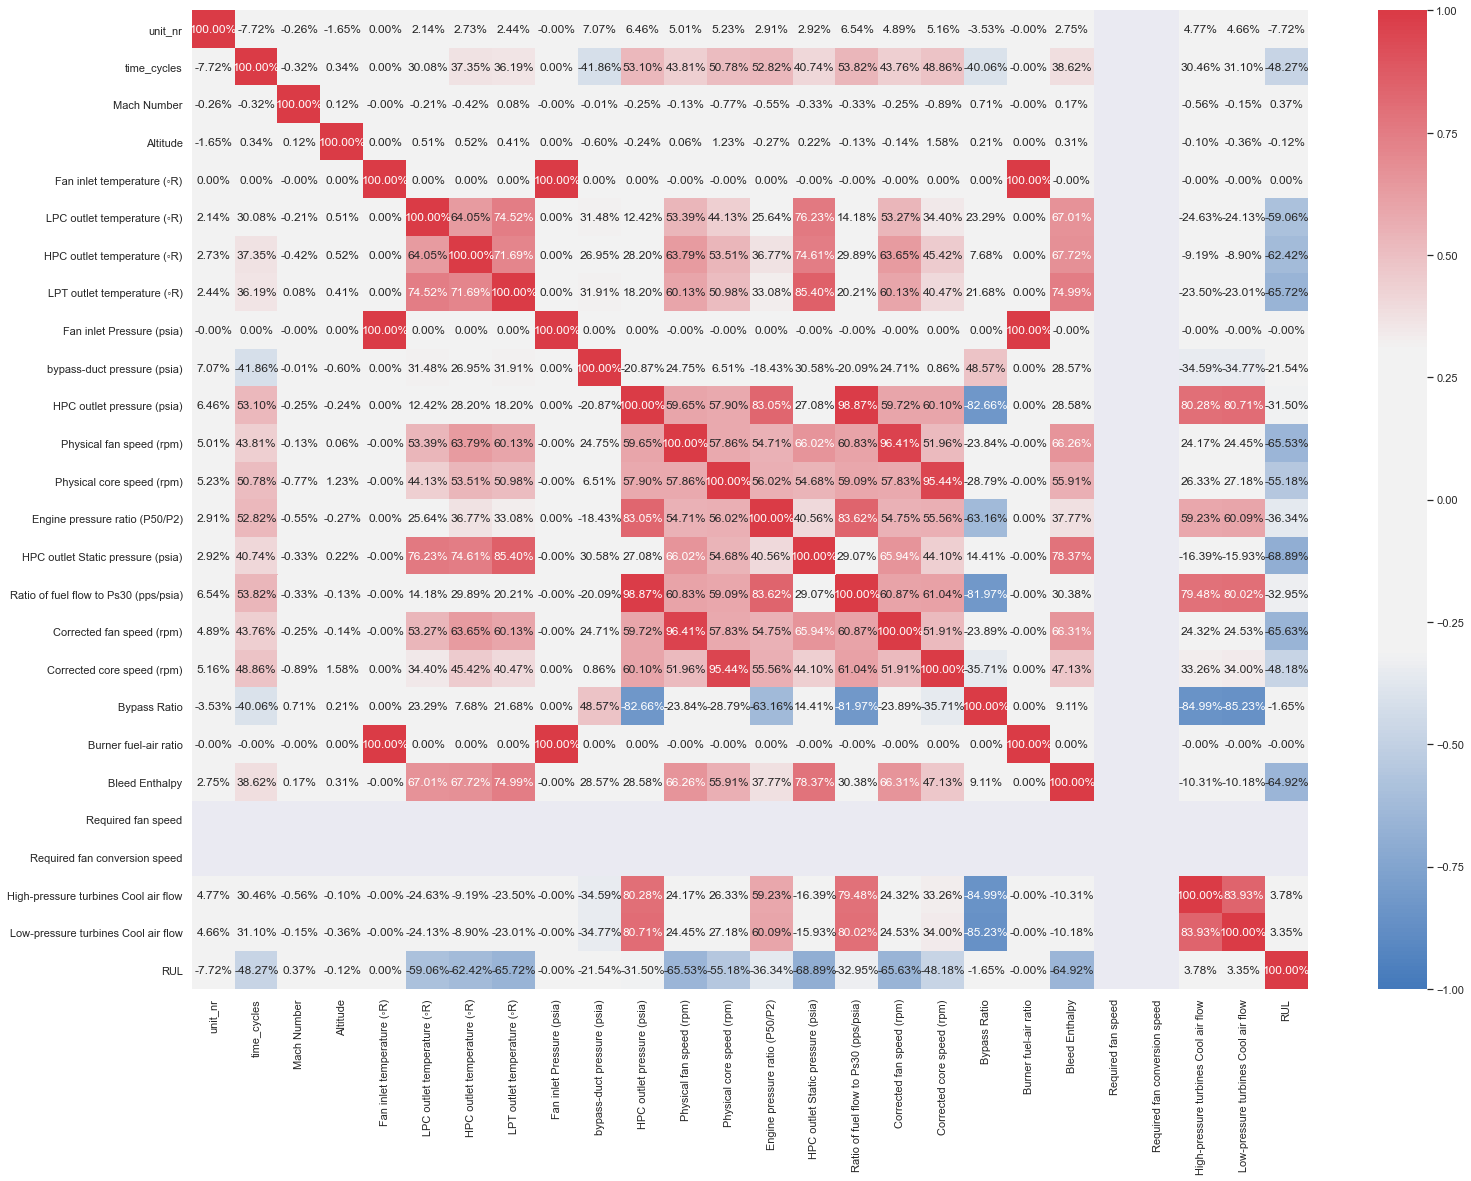

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 18))
correlation_matrix = train.corr()

# Define a custom color map with varying shades
cmap = sns.diverging_palette(250, 10, sep=80, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2%', vmin=-1, vmax=1)
plt.show()


In [23]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

LPC outlet temperature (◦R)         -0.590564
HPC outlet temperature (◦R)         -0.624236
LPT outlet temperature (◦R)         -0.657224
Physical fan speed (rpm)            -0.655345
Physical core speed (rpm)           -0.551843
HPC outlet Static pressure (psia)   -0.688915
Corrected fan speed (rpm)           -0.656340
Bleed Enthalpy                      -0.649220
RUL                                  1.000000
Name: RUL, dtype: float64

In [24]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[0:]
list_relevant_features

Index(['LPC outlet temperature (◦R)', 'HPC outlet temperature (◦R)',
       'LPT outlet temperature (◦R)', 'Physical fan speed (rpm)',
       'Physical core speed (rpm)', 'HPC outlet Static pressure (psia)',
       'Corrected fan speed (rpm)', 'Bleed Enthalpy', 'RUL'],
      dtype='object')

In [25]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [26]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [27]:
train.head(5)

,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Corrected fan speed (rpm),Bleed Enthalpy,RUL
0,642.36,1583.23,1396.84,2387.96,9062.17,47.30,2388.01,391,258
1,642.50,1584.69,1396.89,2388.00,9061.78,47.23,2388.03,392,257
2,642.18,1582.35,1405.61,2388.03,9070.23,47.22,2388.00,391,256
3,642.92,1585.61,1392.27,2388.00,9064.57,47.24,2388.08,392,255
4,641.68,1588.63,1397.65,2388.04,9076.14,47.15,2388.03,392,254


## Seperating Train & Test Data

In [28]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Corrected fan speed (rpm),Bleed Enthalpy
0,642.36,1583.23,1396.84,2387.96,9062.17,47.30,2388.01,391
1,642.50,1584.69,1396.89,2388.00,9061.78,47.23,2388.03,392
2,642.18,1582.35,1405.61,2388.03,9070.23,47.22,2388.00,391
3,642.92,1585.61,1392.27,2388.00,9064.57,47.24,2388.08,392
4,641.68,1588.63,1397.65,2388.04,9076.14,47.15,2388.03,392


In [29]:
test.head(5)

,Mach Number,Altitude,Sea-level temperature,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),bypass-duct pressure (psia),HPC outlet pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,0.0021,0.0002,100.0,518.67,642.59,1592.40,1409.87,14.62,21.58,560.53,...,528.05,2388.23,8158.77,8.2966,0.03,393,2388,100.0,39.43,23.5679
1,-0.0005,0.0002,100.0,518.67,642.56,1587.42,1409.69,14.62,21.61,553.33,...,520.90,2388.17,8128.04,8.4514,0.03,392,2388,100.0,38.83,23.2821
2,-0.0011,-0.0004,100.0,518.67,642.75,1591.93,1417.66,14.62,21.60,563.61,...,531.36,2388.33,8173.56,8.3057,0.03,395,2388,100.0,39.27,23.6440
3,-0.0014,-0.0000,100.0,518.67,642.28,1584.68,1406.56,14.62,21.61,552.75,...,521.27,2388.09,8133.78,8.4337,0.03,392,2388,100.0,38.70,23.3804
4,-0.0001,-0.0003,100.0,518.67,642.15,1580.59,1397.26,14.62,21.58,553.82,...,521.74,2387.96,8132.51,8.3900,0.03,390,2388,100.0,38.89,23.4463


In [30]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Corrected fan speed (rpm),Bleed Enthalpy
0,642.59,1592.40,1409.87,2388.22,9085.50,47.53,2388.23,393
1,642.56,1587.42,1409.69,2388.18,9050.97,47.71,2388.17,392
2,642.75,1591.93,1417.66,2388.31,9091.69,47.68,2388.33,395
3,642.28,1584.68,1406.56,2388.07,9048.23,47.26,2388.09,392
4,642.15,1580.59,1397.26,2387.96,9050.89,47.09,2387.96,390


In [31]:
y_test.head(5)

,RUL
0,44
1,51
2,27
3,120
4,101


In [32]:
y_train.describe()

count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64

In [33]:

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [34]:
y_test.describe()

,RUL
count,100.000000
mean,75.320000
std,41.604166
min,6.000000
25%,43.250000
50%,77.500000
75%,115.000000
max,145.000000


In [35]:
y_test= y_test.clip(upper=103)
y_test.head(5)

,RUL
0,44
1,51
2,27
3,103
4,101


## Building Model

In [36]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [37]:
# Model : Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(90, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [38]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [39]:
# Reshape input for LSTM 
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [40]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [41]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)



In [42]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
618/618 [==============================] - 4s 3ms/step - loss: 4109.7866 - mae: 55.2461 - val_loss: 1764.3582 - val_mae: 34.4548
Epoch 2/50
618/618 [==============================] - 2s 3ms/step - loss: 734.7311 - mae: 21.2094 - val_loss: 239.8078 - val_mae: 12.2271
Epoch 3/50
618/618 [==============================] - 2s 3ms/step - loss: 187.7033 - mae: 9.8229 - val_loss: 157.6505 - val_mae: 8.4149
Epoch 4/50
618/618 [==============================] - 2s 3ms/step - loss: 158.8537 - mae: 8.3598 - val_loss: 157.7673 - val_mae: 8.2412
Epoch 5/50
618/618 [==============================] - 2s 2ms/step - loss: 153.9015 - mae: 8.0700 - val_loss: 158.0279 - val_mae: 8.1392


In [43]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

773/773 [==============================] - 1s 1ms/step
train set RMSE:12.748545494477318, R2:0.8415245167905936


In [44]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:15.17773803377711, R2:0.7908118605629043


In [45]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812


## Bi-TRNN model

In [46]:
# Model: Bidirectional TRNN 
def Bi_trnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [47]:
# Preprocess data for Bi-TRNN
scaler_bi_trnn = StandardScaler()
X_train_bi_trnn = scaler_bi_trnn.fit_transform(X_train)
X_test_bi_trnn = scaler_bi_trnn.transform(X_test)


In [48]:
# Reshape input for Bi-TRNN 
X_train_bi_trnn = X_train_bi_trnn.reshape((X_train_bi_trnn.shape[0], X_train_bi_trnn.shape[1], 1))
X_test_bi_trnn = X_test_bi_trnn.reshape((X_test_bi_trnn.shape[0], X_test_bi_trnn.shape[1], 1))


In [49]:
# Build and train the Bidirectional TRNN model
input_shape_bi_trnn = (X_train_bi_trnn.shape[1], X_train_bi_trnn.shape[2])
bi_trnn_model = Bi_trnn(input_shape_bi_trnn)


In [50]:
# Define early stopping to prevent overfitting
early_stopping_bi_trnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [51]:
# Train the model
bi_trnn_model.fit(X_train_bi_trnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_trnn])


Epoch 1/50
618/618 [==============================] - 3s 3ms/step - loss: 706.7243 - mae: 16.2764 - val_loss: 175.7596 - val_mae: 9.4443
Epoch 2/50
618/618 [==============================] - 2s 3ms/step - loss: 175.6369 - mae: 9.1121 - val_loss: 182.8479 - val_mae: 9.5917
Epoch 3/50
618/618 [==============================] - 2s 3ms/step - loss: 171.6038 - mae: 9.0863 - val_loss: 175.3795 - val_mae: 10.1418
Epoch 4/50
618/618 [==============================] - 2s 3ms/step - loss: 163.3521 - mae: 8.6960 - val_loss: 165.5120 - val_mae: 8.1320
Epoch 5/50
618/618 [==============================] - 2s 3ms/step - loss: 162.7305 - mae: 8.6116 - val_loss: 169.3343 - val_mae: 9.5465
Epoch 6/50
618/618 [==============================] - 2s 3ms/step - loss: 160.7986 - mae: 8.5921 - val_loss: 174.2227 - val_mae: 8.5622
Epoch 7/50
618/618 [==============================] - 2s 3ms/step - loss: 159.3161 - mae: 8.4925 - val_loss: 183.8553 - val_mae: 9.4990
Epoch 8/50
618/618 [==========================

In [52]:
# Evaluate on train data
y_hat_train_bi_trnn = bi_trnn_model.predict(X_train_bi_trnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bi_trnn, 'train')


773/773 [==============================] - 1s 1ms/step
train set RMSE:12.433441601515158, R2:0.8492617301706836


In [53]:
# Evaluate on test data
y_hat_test_bi_trnn = bi_trnn_model.predict(X_test_bi_trnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bi_trnn, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:15.374103881481869, R2:0.7853639959421683


In [54]:

# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiTRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812
1,BiTRNN,12.433442,0.849262,15.374104,0.785364


## Bi-GRU model

In [55]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [56]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [57]:
# Reshape input for GRU 
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [58]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [59]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [60]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
618/618 [==============================] - 3s 3ms/step - loss: 3557.5154 - mae: 50.2130 - val_loss: 740.3032 - val_mae: 21.9042
Epoch 2/50
618/618 [==============================] - 1s 2ms/step - loss: 296.7753 - mae: 12.9866 - val_loss: 161.6449 - val_mae: 9.2090
Epoch 3/50
618/618 [==============================] - 1s 2ms/step - loss: 166.7732 - mae: 8.8673 - val_loss: 153.9694 - val_mae: 8.6364
Epoch 4/50
618/618 [==============================] - 1s 2ms/step - loss: 156.5737 - mae: 8.2603 - val_loss: 151.2016 - val_mae: 8.1471
Epoch 5/50
618/618 [==============================] - 1s 2ms/step - loss: 152.0408 - mae: 7.9307 - val_loss: 157.1466 - val_mae: 8.2053
Epoch 6/50
618/618 [==============================] - 1s 2ms/step - loss: 149.7958 - mae: 7.7829 - val_loss: 158.1075 - val_mae: 7.9438


In [61]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


773/773 [==============================] - 1s 1ms/step
train set RMSE:12.372332818058721, R2:0.8507398077738553


In [62]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


4/4 [==============================] - 0s 2ms/step
test set RMSE:15.256464155496621, R2:0.7886361369217957


In [63]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [64]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812
1,BiTRNN,12.433442,0.849262,15.374104,0.785364
2,BiGRU,12.372333,0.850740,15.256464,0.788636


## Prognet model

In [65]:
from tensorflow.keras.layers import LSTM

# Model: ProgNet (Progressive Neural Network) with LSTM layers
def build_prognet_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [66]:
# Preprocess data for ProgNet
scaler_prognet = StandardScaler()
X_train_prognet = scaler_prognet.fit_transform(X_train)
X_test_prognet = scaler_prognet.transform(X_test)


In [67]:
# Reshape input for LSTM 
X_train_prognet = X_train_prognet.reshape((X_train_prognet.shape[0], X_train_prognet.shape[1], 1))

# Build and train the ProgNet model
input_shape_prognet = (X_train_prognet.shape[1], X_train_prognet.shape[2])
prognet_model = build_prognet_model(input_shape_prognet)


In [68]:
# Define early stopping to prevent overfitting
early_stopping_prognet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [69]:
# Train the model
prognet_model.fit(X_train_prognet, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_prognet])


Epoch 1/50
618/618 [==============================] - 5s 6ms/step - loss: 922.8117 - mae: 19.3530 - val_loss: 180.4963 - val_mae: 9.1802
Epoch 2/50
618/618 [==============================] - 3s 6ms/step - loss: 194.6786 - mae: 9.9849 - val_loss: 167.1821 - val_mae: 8.8029
Epoch 3/50
618/618 [==============================] - 3s 6ms/step - loss: 179.6344 - mae: 9.3894 - val_loss: 164.5711 - val_mae: 8.6069
Epoch 4/50
618/618 [==============================] - 3s 6ms/step - loss: 173.0364 - mae: 9.1035 - val_loss: 173.1343 - val_mae: 8.6711
Epoch 5/50
618/618 [==============================] - 3s 6ms/step - loss: 167.2033 - mae: 8.7940 - val_loss: 179.0178 - val_mae: 9.7234
Epoch 6/50
618/618 [==============================] - 3s 6ms/step - loss: 170.0676 - mae: 8.9779 - val_loss: 172.7573 - val_mae: 8.6537
Epoch 7/50
618/618 [==============================] - 3s 6ms/step - loss: 166.6173 - mae: 8.7807 - val_loss: 172.2648 - val_mae: 8.6679
Epoch 8/50
618/618 [===========================

In [70]:
# Evaluate on train data
y_hat_train_prognet = prognet_model.predict(X_train_prognet)
RMSE_Train_ProgNet, R2_Train_ProgNet = evaluate(y_train, y_hat_train_prognet, 'train')


773/773 [==============================] - 2s 3ms/step
train set RMSE:12.739094489177237, R2:0.841759398089093


In [71]:
# Reshape input for LSTM 
X_test_prognet = X_test_prognet.reshape((X_test_prognet.shape[0], X_test_prognet.shape[1], 1))

# Evaluate on test data
y_hat_test_prognet = prognet_model.predict(X_test_prognet)

# Now you can proceed with the evaluation
RMSE_Test_ProgNet, R2_Test_ProgNet = evaluate(y_test, y_hat_test_prognet, 'test')


4/4 [==============================] - 0s 7ms/step
test set RMSE:15.66809743924167, R2:0.7770766918138429


In [72]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['ProgNet'],
    'RMSE-Train': [RMSE_Train_ProgNet],
    'R2-Train': [R2_Train_ProgNet],
    'RMSE-Test': [RMSE_Test_ProgNet],
    'R2-Test': [R2_Test_ProgNet]
}), ignore_index=True)

In [73]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812
1,BiTRNN,12.433442,0.849262,15.374104,0.785364
2,BiGRU,12.372333,0.850740,15.256464,0.788636
3,ProgNet,12.739094,0.841759,15.668097,0.777077


## DCNN model

In [74]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [78]:
from tensorflow.keras.layers import GlobalMaxPooling1D

def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # Add MaxPooling1D or GlobalMaxPooling1D based on the input size
    if input_shape[0] // 2 > 2:
        model.add(MaxPooling1D(pool_size=2))
    else:
        model.add(GlobalMaxPooling1D())
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    
    # Add MaxPooling1D or GlobalMaxPooling1D based on the input size
    if (input_shape[0] // 2 // 2) > 2:
        model.add(MaxPooling1D(pool_size=2))
    else:
        model.add(GlobalMaxPooling1D())
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [79]:
# Preprocess data for DCNN
scaler_dcnn = StandardScaler()
X_train_dcnn = scaler_dcnn.fit_transform(X_train)
X_test_dcnn = scaler_dcnn.transform(X_test)

In [80]:
# Reshape input for DCNN (assuming your data is sequential)
X_train_dcnn = X_train_dcnn.reshape((X_train_dcnn.shape[0], X_train_dcnn.shape[1], 1))
X_test_dcnn = X_test_dcnn.reshape((X_test_dcnn.shape[0], X_test_dcnn.shape[1], 1))


In [81]:
# Build and train the DCNN model
input_shape_dcnn = (X_train_dcnn.shape[1], X_train_dcnn.shape[2])
dcnn_model = build_dcnn_model(input_shape_dcnn)

In [82]:
# Define early stopping to prevent overfitting
early_stopping_dcnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [83]:
# Train the model
dcnn_model.fit(X_train_dcnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dcnn])


Epoch 1/50
618/618 [==============================] - 2s 2ms/step - loss: 1074.3821 - mae: 21.4239 - val_loss: 170.2100 - val_mae: 8.8849
Epoch 2/50
618/618 [==============================] - 1s 2ms/step - loss: 172.3379 - mae: 8.7558 - val_loss: 176.6382 - val_mae: 9.5450
Epoch 3/50
618/618 [==============================] - 1s 2ms/step - loss: 162.4812 - mae: 8.3368 - val_loss: 164.2628 - val_mae: 9.1010
Epoch 4/50
618/618 [==============================] - 1s 2ms/step - loss: 158.1982 - mae: 8.2408 - val_loss: 162.4550 - val_mae: 8.4281
Epoch 5/50
618/618 [==============================] - 1s 2ms/step - loss: 154.4292 - mae: 8.0952 - val_loss: 176.4546 - val_mae: 9.6721
Epoch 6/50
618/618 [==============================] - 1s 2ms/step - loss: 153.2265 - mae: 8.0707 - val_loss: 164.6698 - val_mae: 8.0599
Epoch 7/50
618/618 [==============================] - 1s 2ms/step - loss: 152.5996 - mae: 8.0370 - val_loss: 165.4869 - val_mae: 8.6422
Epoch 8/50
618/618 [==========================

In [84]:
# Evaluate on train data
y_hat_train_dcnn = dcnn_model.predict(X_train_dcnn)
RMSE_Train_DCNN, R2_Train_DCNN = evaluate(y_train, y_hat_train_dcnn, 'train')


773/773 [==============================] - 1s 948us/step
train set RMSE:12.336189924586996, R2:0.8516105919068976


In [85]:
# Evaluate on test data
y_hat_test_dcnn = dcnn_model.predict(X_test_dcnn)
RMSE_Test_DCNN, R2_Test_DCNN = evaluate(y_test, y_hat_test_dcnn, 'test')


4/4 [==============================] - 0s 5ms/step
test set RMSE:16.271685752617582, R2:0.7595703365272498


In [86]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['DCNN'],
    'RMSE-Train': [RMSE_Train_DCNN],
    'R2-Train': [R2_Train_DCNN],
    'RMSE-Test': [RMSE_Test_DCNN],
    'R2-Test': [R2_Test_DCNN]
}), ignore_index=True)

In [87]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812
1,BiTRNN,12.433442,0.849262,15.374104,0.785364
2,BiGRU,12.372333,0.850740,15.256464,0.788636
3,ProgNet,12.739094,0.841759,15.668097,0.777077
4,DCNN,12.336190,0.851611,16.271686,0.759570


## Ensemble model using Random Forest Regressor

In [88]:
# Concatenate predictions from ProgNet and BiGRU for training data
X_train_ensemble = np.concatenate((y_hat_train_bi_trnn, y_hat_train_bi_gru, y_hat_train_lstm), axis=1)

# Concatenate predictions from ProgNet and BiGRU for test data
X_test_ensemble = np.concatenate((y_hat_test_bi_trnn,y_hat_test_bi_gru, y_hat_test_lstm), axis=1)


In [89]:
# Model : Random Forest (instead of Decision Tree)
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)


In [90]:
# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)


RandomForestRegressor(max_depth=10, random_state=42)

In [91]:
# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')


train set RMSE:10.834559123371914, R2:0.8855374818439248


In [92]:
# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')


test set RMSE:15.937463408628826, R2:0.7693458073818691


In [93]:


# Reshape arrays to have shape (n_samples, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_hat_test_rf_reshaped = y_hat_test_rf.reshape(-1, 1)

# Create DataFrame with actual and predicted RUL
df_results = pd.DataFrame({'Actual RUL': y_test_reshaped.flatten(), 'Predicted RUL': y_hat_test_rf_reshaped.flatten()})

# Display the DataFrame
print(df_results)


    Actual RUL  Predicted RUL
0           44      50.882852
1           51      81.615613
2           27      29.898894
3          103     101.694667
4          101     102.583361
5           99      98.175289
6           71      82.434616
7           55      71.731404
8           55      81.582675
9           66      96.847505
10          77      77.068804
11         103      99.600155
12         103      89.133383
13          31      52.590253
14         103     100.545417
15          56     102.419256
16         103     100.146416
17         103     100.914366
18          85      97.371726
19          56      60.300304
20          18      26.491134
21         103      99.425241
22          78      74.253467
23           9       8.472998
24          58      79.799227
25          11      28.089510
26          88      90.966077
27         103      96.575247
28         103      99.582920
29          89      81.974811
30          79      82.341086
31          55      44.284584
32        

In [94]:




# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812
1,BiTRNN,12.433442,0.849262,15.374104,0.785364
2,BiGRU,12.372333,0.850740,15.256464,0.788636
3,ProgNet,12.739094,0.841759,15.668097,0.777077
4,DCNN,12.336190,0.851611,16.271686,0.759570
5,Random Forest (Ensemble),10.834559,0.885537,15.937463,0.769346


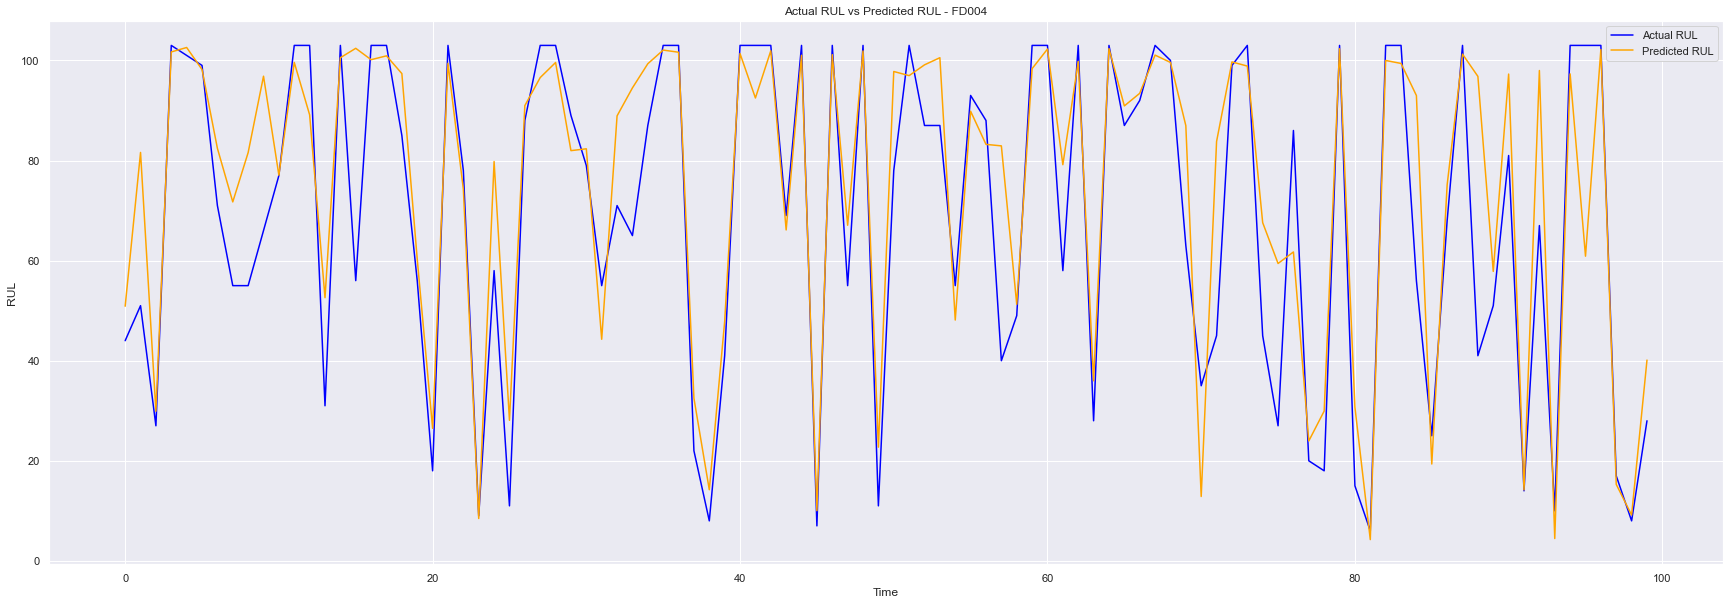

In [96]:
plt.figure(figsize=(30, 10))

# Line chart for actual RUL
plt.plot(y_test, label='Actual RUL', linestyle='-', color='blue')

# Line chart for predicted RUL
plt.plot(y_hat_test_rf, label='Predicted RUL', linestyle='-', color='orange')

plt.title('Actual RUL vs Predicted RUL - FD004')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

In [95]:
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.748545,0.841525,15.177738,0.790812
1,BiTRNN,12.433442,0.849262,15.374104,0.785364
2,BiGRU,12.372333,0.850740,15.256464,0.788636
3,ProgNet,12.739094,0.841759,15.668097,0.777077
4,DCNN,12.336190,0.851611,16.271686,0.759570
5,Random Forest (Ensemble),10.834559,0.885537,15.937463,0.769346
